# はじめる

このノートブックを実行する前に、次のことを確認してください。

1. **ローカルモジュール：** 必要なローカルPythonファイル（`items.py`、` loaders.py`、`test.py`）をColab Runtimeの一時ストレージにアップロードする。これを行うには、左サイドバーのフォルダー・アイコン、次にアップロード・アイコンをクリックして、ファイルを選択。
2. 左側のサイドバーのキーアイコンをクリックし、[新しいシークレット]をクリックし、「hf_token」という名前のトークンを追加。
3. これらの手順が完了したら、残りのノートブックセルを順番に実行できます。

In [1]:
# コースの環境に合わせて、ローカル環境から正確なバージョンをインストール
!pip install --upgrade pip

# 必要なライブラリの特定のバージョンをインストール
!pip install datasets==3.6.0
!pip install transformers==4.51.3
!pip install huggingface_hub==0.31.2
!pip install matplotlib==3.10.3
!pip install numpy==1.26.4
!pip install python-dotenv==1.1.0
!pip install tqdm==4.67.1

In [2]:
# import

import os
import random
import pickle

from dotenv import load_dotenv
from huggingface_hub import login

import numpy as np
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [3]:
# ColabのシークレットからHugging Faceアクセストークンを取得
# このトークンは、Hugging Face Hubと対話するために必要
from google.colab import userdata
# userdata.get('HF_TOKEN') # 危ない（笑）

In [4]:
# ローカルファイルからカスタムクラスをインポート（items.pyおよびloaders.py）
# これらのファイルは（、前述の通り）、Colab Runtimeの一時ストレージに手動で追加する必要がある。
from loaders import ItemLoader
from items import Item

In [5]:
# Matplotlibのバックエンドを設定して、ノートブックにインラインでプロットを表示
%matplotlib inline

## アイテムローダーコード

`loaders.py`を見る - 私たちの生活を楽にするための便利なコードがいくつかあります

```python
# 前回と同じデータセットをロード
items = ItemLoader("Home_and_Kitchen").load()
```

```text
Loading dataset Home_and_Kitchen
README.md: 30.3k/? [00:00<00:00, 464kB/s]
Amazon-Reviews-2023.py: 39.6k/? [00:00<00:00, 638kB/s]
meta_Home_and_Kitchen.jsonl: 100% 11.8G/11.8G [08:08<00:00, 24.1MB/s]
Generating full split: 3735584/0 [16:57<00:00, 4662.68 examples/s]
Loading dataset shards: 100% 21/21 [00:29<00:00,  1.42s/it]
100%|██████████| 3736/3736 [4:12:03<00:00,  4.05s/it]
Completed Home_and_Kitchen with 1,112,910 datapoints in 278.3 mins
```

- ダウンロード：Hugging Face Hubから *.py, *.jsonl を取得
- スクリプト実行：Amazon-Reviews-2023.py データ読込を定義
- スプリット生成：データ全体をtrain, test, fullなどに分割
- シャーディング：データを小さなファイルに分けて高速アクセス・キャッシュ化
- 各イテレーション  
1シャード：4秒、全体3736シャード：約4時間、1シャード：300レコード程度
  - Arrow化	メモリ効率の良いApache Arrow形式で保存
  - キャッシュ化	~/.cache/huggingface/datasets に保存して次回高速化

```python
# アイテムを探す
print(items[1].prompt)
```
```text
How much does this cost to the nearest dollar?

Foaming Soap Dispenser Thick Ceramic Foam Hand Soap Dispenser for Bathroom or Kitchen Sink, Liquid Pump Bottles for Hand soap, Body Wash, 2 Pack Black
Saving money You can DIY foam soap which will save you hundreds of dollars ( create foam just need to dilute the regular soap with water in a ratio of 1 3 ). One pump foams the right amount of soap for a thorough hand wash. High Quality made of thickened ceramic material, which is sturdy, durable and wear-resistant. The base has a nice heavy weight so it won’t slide or tip when used. Simple use with 3.15 inch Wide opening and large pump button, you can refill and press very easily, even so easy for kids to use. Moreover, smoothly surface make it easy to clean

Price is $25.00
```

## 今、スケールアップします

大規模なホーム小売店で見つけるかもしれないすべてのアイテムのすべてのデータセットを見てみましょう - 電気、電子、オフィス関連で、衣服、美容、書籍ではありません。

1つのデータセットに４時間以上 ... Google Colabのセッション時間内に完了しないのでデータセット毎にpickleファイルに永続化して、最後に統合することにした。

In [6]:
# Colab Runtime環境で利用可能なCPUコアとRAMを確認してプリント
# これはデータ処理に使用されるリソースを理解するのに役立つ
import psutil
print(f"CPU cores: {psutil.cpu_count()}")
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")

CPU cores: 2
Available RAM: 10.8 GB


In [7]:
# Googleドライブをマウントして、ドライブ内のファイルにアクセス
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# ロードされるデータセット名（Amazon製品カテゴリ）のリストを定義
dataset_names = [
    "Home_and_Kitchen",
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [9]:
# ファイル操作
import shutil

source_path = '/content/'
destination_path = '/content/drive/My Drive/'

items = []
for dataset_name in dataset_names:

    pkl_file = f'items_{dataset_name}.pkl'
    if os.path.exists(destination_path + pkl_file):
        print(f"{pkl_file} は既に存在するのでスキップします")
        continue

    loader = ItemLoader(dataset_name)
    #items.extend(loader.load())
    loaded_items = loader.load()

    # 各データセット毎に別々のpickleファイルに保存
    with open(pkl_file, 'wb') as f:
        pickle.dump(loaded_items, f)

    # ファイルをコピー
    shutil.copyfile(source_path + pkl_file, destination_path + pkl_file)
    # 確認メッセージをPrint
    print(f"Copied {source_path + pkl_file} to {destination_path + pkl_file}")

# さて、コーヒーブレイクの時間!!（VM次第で、1-2日かかる（笑））
# ちなみに、私は最大のデータセットを最初に置きます。それはより速くなります。

items_Home_and_Kitchen.pkl は既に存在するのでスキップします
items_Automotive.pkl は既に存在するのでスキップします
items_Electronics.pkl は既に存在するのでスキップします
items_Office_Products.pkl は既に存在するのでスキップします
items_Tools_and_Home_Improvement.pkl は既に存在するのでスキップします
items_Cell_Phones_and_Accessories.pkl は既に存在するのでスキップします
items_Toys_and_Games.pkl は既に存在するのでスキップします
items_Appliances.pkl は既に存在するのでスキップします
items_Musical_Instruments.pkl は既に存在するのでスキップします


In [10]:
# 最後に統合
items = []
for dataset_name in dataset_names:
    pkl_file = f'items_{dataset_name}.pkl'
    with open(destination_path + pkl_file, 'rb') as f:
        loaded_items = pickle.load(f)
        items.extend(loaded_items)

In [11]:
# すべてのデータセットからロードされたアイテムの総数を印刷
print(f"A grand total of {len(items):,} items")

A grand total of 3,924,318 items


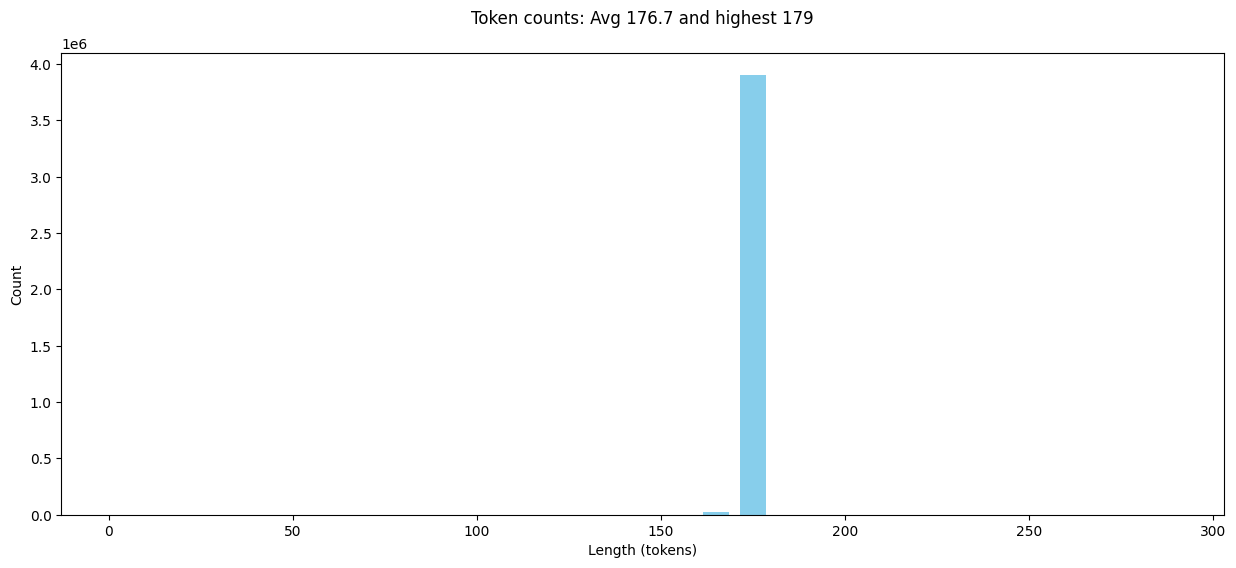

In [12]:
# トークン数の分布を再度プロット
# MIN_TOKENS = 150 - MAX_TOKENS = 160 の範囲内なので
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

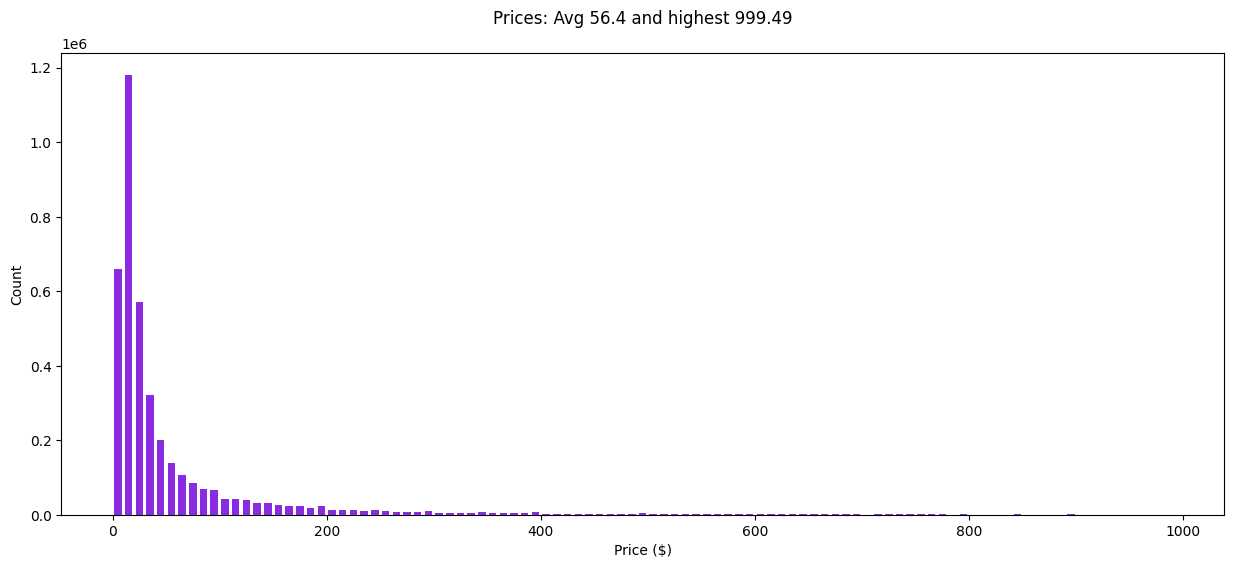

In [13]:
# 価格の分布を再度プロット

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

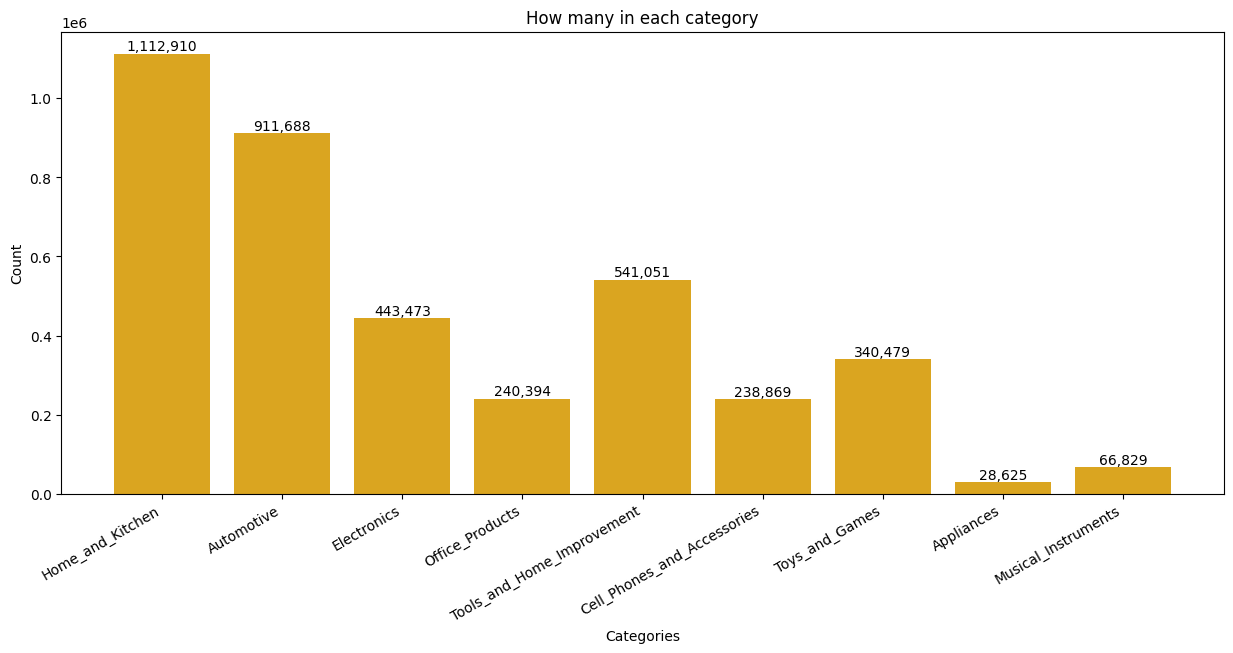

In [14]:
#「アイテムのカテゴリ毎の数」を棒グラフ（バーチャート）で可視化

# カウント集計
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

# 集計したカテゴリ名 (categories) と、その個数 (counts) のリストを作成
categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# カテゴリ別のバーチャート
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# 各バーの上に値ラベルを追加します
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# チャートを表示します
plt.show()

# 客観的

価格のバランスが取れているデータセットを作成します。安価なアイテムにはあまり重くなりませんでしたが、平均は60ドルを超えています。カテゴリのバランスを取るようにしてください - 自動車アイテムは少なくなります。

In [15]:
# 価値でスロット分けした商品リストを作成（slots は list を返す dict）

slots = defaultdict(list) # キーが空の場合、空の list ([]) を自動で生成する dict
for item in items:
    slots[round(item.price)].append(item)

In [16]:
# 価格の範囲ごと（slots）にアイテムを分け、サンプル・データセット（sample）を構築する
# ただし、自動車カテゴリ以外のアイテムに多くの重みを与えて抽出し、価格帯毎に偏りを抑える。

# 乱数シードの固定
np.random.seed(42)
random.seed(42)

# サンプルリスト生成
sample = []
for i in range(1, 1000): # 価格帯ごと（1-999$）
    slot = slots[i] # 当該価格の商品数
    if i>=240:              # 240＄以上なら全件追加（数が少ないので）
        sample.extend(slot)
    elif len(slot) <= 1200: # 1200件以下なら全件追加
        sample.extend(slot)
    else:                   # 上記以外、重みをAutomotiveは1、他は5にして1200件サンプリング
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 454,271 items in the sample


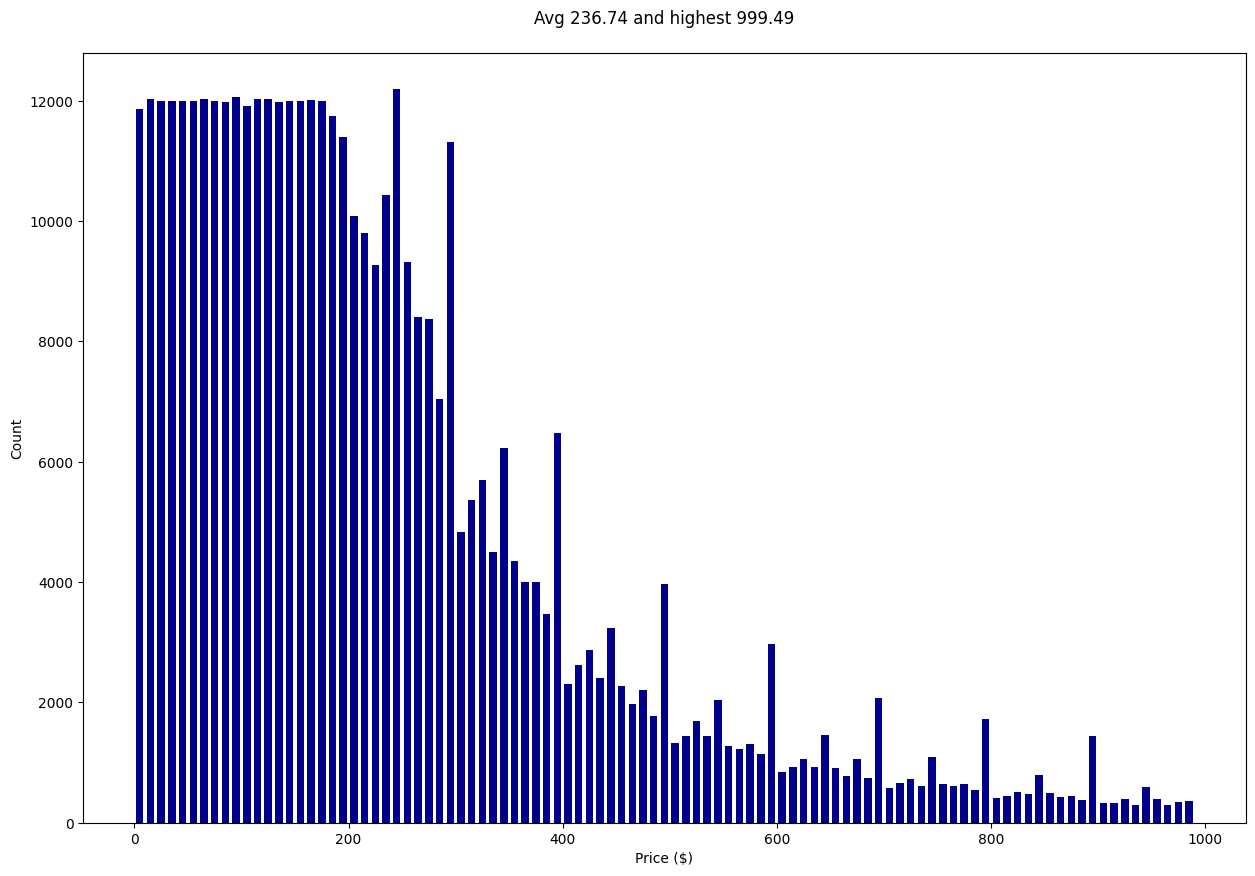

In [17]:
# サンプルの価格の分布をプロット
# ・200＄位から1,200件を下回る。
# ・X99＄のスロットは商品数は増える。
prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

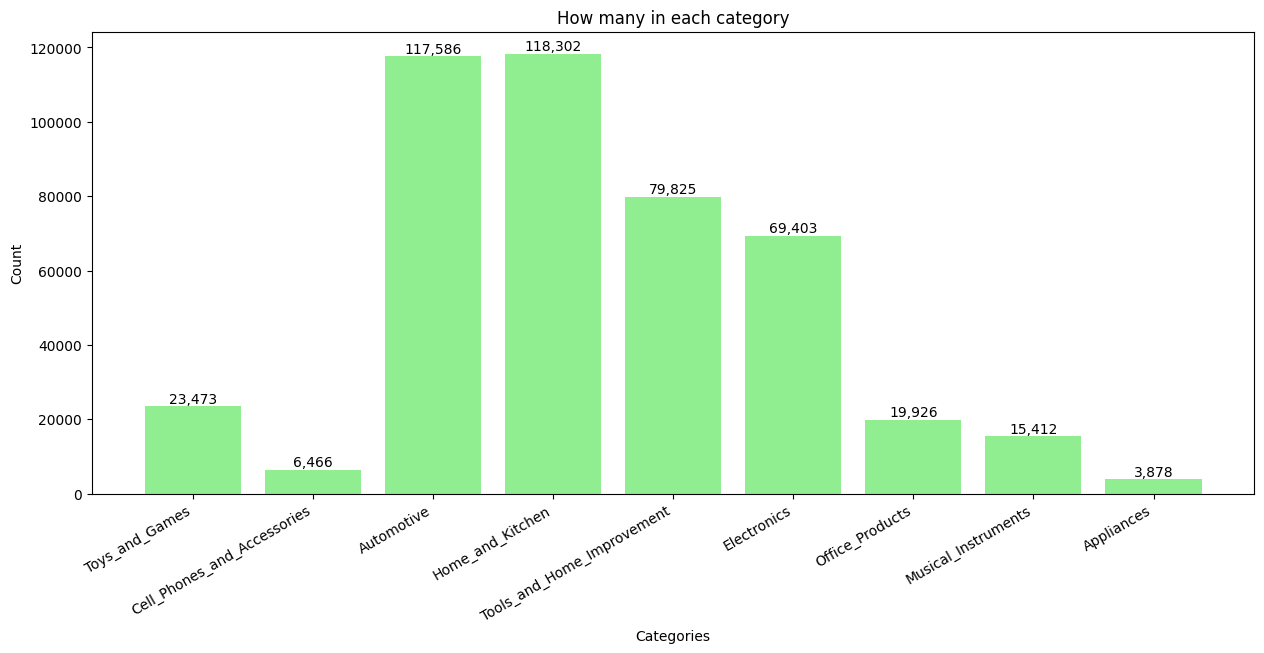

In [18]:
# 「各カテゴリにいくつのアイテムがあるか」を分かりやすいバーチャートにして、各カテゴリの上に件数も明示

# カテゴリごとの件数を数える
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

# カテゴリ名と件数のリスト作成
categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# バーチャートを作成
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# チャートをカスタマイズ
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# 各バーの上に値ラベルを追加
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# チャートを表示
plt.show()

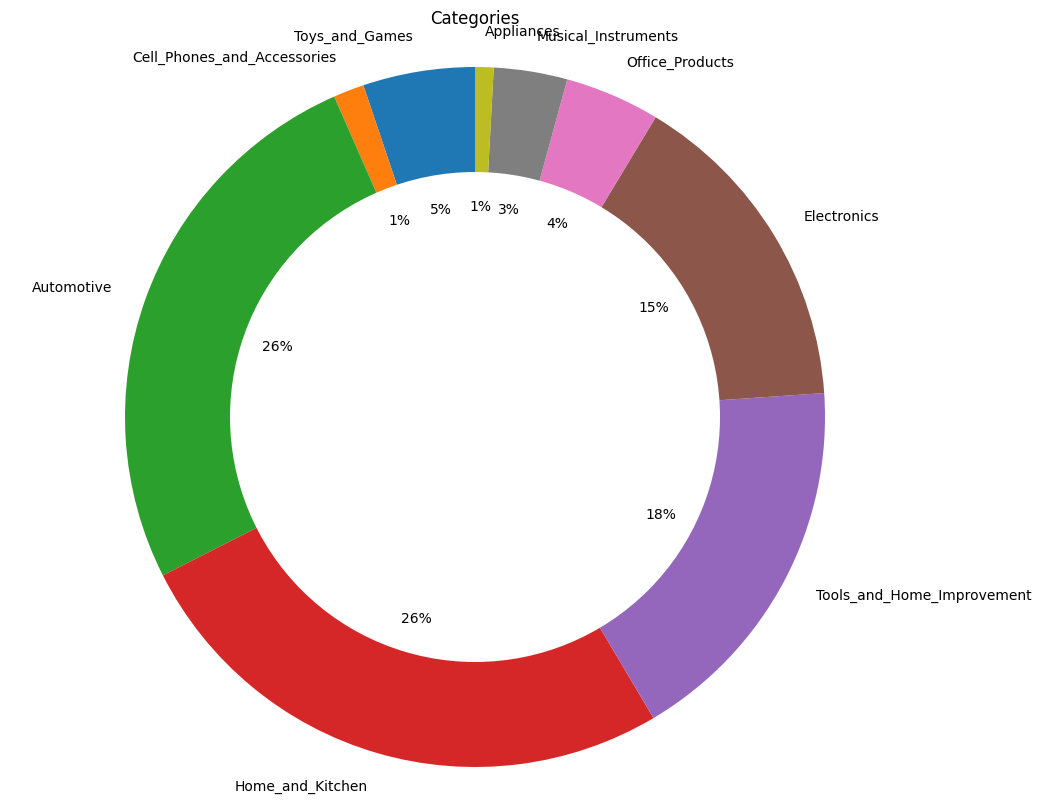

In [19]:
# 別の視点については「ドーナツチャート（円グラフ）を見てみましょう

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# 中央に円を追加してドーナツチャートを作成（オプション）
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# 平等なアスペクト比は、パイが円として描かれることを保証
plt.axis('equal')

plt.show()

# データセットキュレーション！

優れたデータセットを作成しました。

いくつかの最終チェックをしましょう

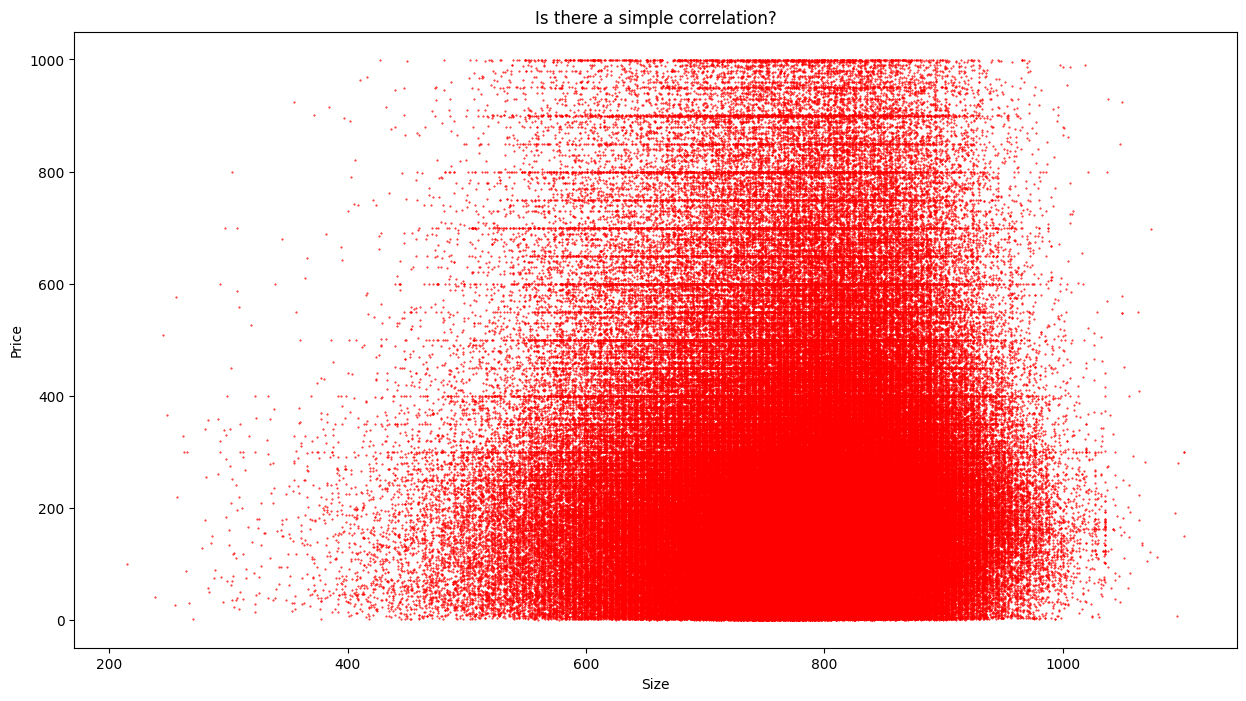

In [20]:
# プロンプト文字数と価格の関係は？

# 文字数と価格の間にうっすら相関関係を確認できる。
sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# 散布図を作成
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# ラベルとタイトルを追加
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# プロットを表示
plt.show()

In [21]:
# プロンプトと、下10トークンの確認
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [22]:
report(sample[398000])

How much does this cost to the nearest dollar?

HOMCOM Tufted Power Lift Chair, Recliner Sofa Chair with Remote Control, Cup Holders and Side Pockets - Dark Grey
- Extra Help - This power lift chair has a motor that assists you in sitting down and standing up if you are elderly or disabled. - Sit Back and Relax - The lift chairs recliners for elderly reclines up to 145°, and you can adjust it to any position you like for reading, watching TV, or taking a nap. The cushion is 20.5 deep and 22 wide, which allows you to move around and find the position that feels best. The built-in footrest will enable you to stretch your legs and keep a relaxed body posture. - Super Comfy - The pocket spring system on this power recliner chair

Price is $452.00
[48520, 10670, 10716, 271, 7117, 374, 400, 21098, 13, 410]
[' recl', 'iner', ' chair', '\n\n', 'Price', ' is', ' $', '452', '.', '00']


## 観察

Llamaトークナイザーの興味深い点は、GPT-4oで見たように、1〜999のすべての数値が1トークンにマッピングされることです。同じことは、すべての数字をトークンにマッピングするQWEN2、GEMMA、およびPHI3にも当てはまりません。これは、私たちのプロジェクトにとって少し便利であることが判明しますが、重要な要件ではありません。

# ついに

データをトレーニング、テスト、検証データセットに分割する時が来ました。

テスト目的でデータの5％〜10％を使用することが典型的ですが、実際にはこの時点で必要なものよりもはるかに多くあります。トレーニングには400,000ポイントを獲得し、テスト用に2,000ポイントを予約しますが、すべてを使用することはありません。


In [23]:
# データを train / test に分割
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [24]:
# trainのプロンプト
print(train[0].prompt)

How much does this cost to the nearest dollar?

Air Filter HVAC Washable Permanent Foa; Reusable Furnace AC Lifetime Filters dust particulate and more Clean Air for your home Wash and Reuse
MANUFACTURERS INFO Two layers of heavy expanded aluminum, pleated together with a piece of polyurethane foam between make the Perm-A-Foam Filter With 40% more surface area than a regular air filter, this permanent filter is designed for years of filtering the smallest of particles. The FOAM Aluminum filter is a permanent air filter designed for furnaces, air conditioners, air handling units and computer applications where smaller particles of dust and dirt are needed to be removed from the air. The perfect solution for eliminating the need for purchasing a new filter each time it comes times to change the filter. Since it is corrugated,

Price is $43.00


In [25]:
# testのプロンプト
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

IC International Concepts San Remo Counterheight Swivel Counter Height Stool, 24, Pecan
For those who appreciate high quality wood furniture with an elegant look. International Concepts home furnishings will complement any décor. Solid parawood Box seat construction for easy assembly 24 counter height seat Solid wood seat with swivel and auto return mechanism Ready to assemble Dimensions 21\ D x 17\ W x 39\ H, Color Pecan, Brand International Concepts, Size 24\, Style Traditional, Furniture Finish Pecan, Seat Height 24 Inches, Care Instructions Wipe with Dry Cloth, Assembly Required Yes, Pieces 1, Weight 31.7 pounds, model number Rank Home & Kitchen Barstools 4851, Available July 21, 201

Price is $


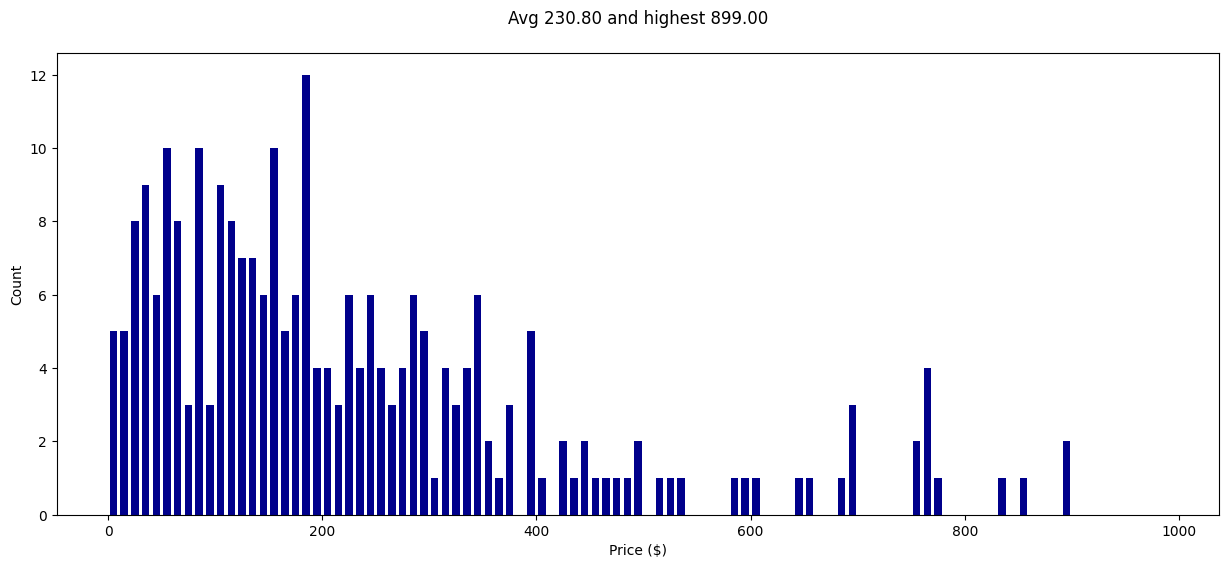

In [26]:
# 最初の250テストポイントで価格の分布をプロットする

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# 最後に - 新しいデータセットをアップロードします

プロンプトに変換し、Hugging Face Hubにアップロードします

In [27]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [28]:
# listからdictを作成

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [29]:
# 実行前に、HFユーザー名に置き換え、Hubにプッシュする準備を完了させる。

hf_user = "nishi74322014"
DATASET_NAME = f"{hf_user}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/190M [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/939k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/nishi74322014/pricer-data/commit/8ed79889a3e8540ff9383906230209c1b697fb7a', commit_message='Upload dataset', commit_description='', oid='8ed79889a3e8540ff9383906230209c1b697fb7a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/nishi74322014/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='nishi74322014/pricer-data'), pr_revision=None, pr_num=None)

アップロードを確認：https://huggingface.co/nishi74322014/datasets

In [30]:
# train / test を pickle

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)
with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

In [31]:
# Googleドライブをマウントして、ドライブ内のファイルにアクセスします
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# ファイル操作のためにShotilモジュールをインポートします
import shutil

# Googleドライブの宛先パスと、ピクルストレーニングデータのソースパスを定義します
# Googleドライブの目的のフォルダーパスに「My Drive/Your_folder_name」を交換してください
destination_path = '/content/drive/My Drive/train.pkl'
source_path = '/content/train.pkl'

# Colab環境からGoogleドライブに漬けられたトレーニングデータファイルをコピーする
shutil.copyfile(source_path, destination_path)

# 確認メッセージを印刷します
print(f"Copied {source_path} to {destination_path}")

Copied /content/train.pkl to /content/drive/My Drive/train.pkl


In [34]:
# ファイル操作のためにShotilモジュールをインポートします
import shutil

# Googleドライブの宛先パスとピクルステストデータのソースパスを定義する
# Googleドライブの目的のフォルダーパスに「My Drive/Your_folder_name」を交換してください
destination_path = '/content/drive/My Drive/test.pkl'
source_path = '/content/test.pkl'

# Colab環境からGoogleドライブに漬物のテストデータファイルをコピーする
shutil.copyfile(source_path, destination_path)

# 確認メッセージを印刷します
print(f"Copied {source_path} to {destination_path}")

Copied /content/test.pkl to /content/drive/My Drive/test.pkl
